In [1]:
! pip install sentence-transformers

In [2]:
! pip install chromadb

In [3]:
! pip install --upgrade pyarrow datasets sentence-transformers

In [4]:
! pip install imbalanced-learn

In [5]:
!pip install imbalanced-learn nltk scikit-learn pandas matplotlib seaborn

In [6]:
!pip install pyarrow

In [7]:
!pip install tabulate

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Added for completeness

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# RAG Libraries
from sentence_transformers import SentenceTransformer
import chromadb
import datasets

# LLM Advisor Libraries
import random # Added for LLM Advisor
import sys # Added for LLM Advisor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Save/Load Models
import joblib
import os # Added for path handling
print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# DOWNLOAD NLTK DATA
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    print("NLTK data downloaded successfully!")
except:
    print("NLTK data already exists")

NLTK data downloaded successfully!


In [3]:
# Load and Explore Data
df = pd.read_csv("Pyschological_data.csv")
print(df.head(3))
print(f"Dataset Shape: {df.shape}")

   Age  Gender Education_Level Employment_Status  Sleep_Hours  Anxiety_Score  \
0   56    Male      Bachelor's           Retired          6.0              4   
1   69  Female      Bachelor's           Retired          8.8             18   
2   46  Female        Master's          Employed          5.3              5   

   Depression_Score  Stress_Level  Family_History_Mental_Illness  \
0                 2             9                              0   
1                 7             6                              0   
2                13             8                              0   

   Chronic_Illnesses Substance_Use  Financial_Stress  Work_Stress  \
0                  0          none                 4            3   
1                  0          none                 1            4   
2                  0          none                 8            7   

   Self_Esteem_Score  Loneliness_Score  \
0                  7                 1   
1                  7                 6   
2  

In [4]:
# Display basic info
print(f"\nColumn Names:\n{df.columns.tolist()}")


Column Names:
['Age', 'Gender', 'Education_Level', 'Employment_Status', 'Sleep_Hours', 'Anxiety_Score', 'Depression_Score', 'Stress_Level', 'Family_History_Mental_Illness', 'Chronic_Illnesses', 'Substance_Use', 'Financial_Stress', 'Work_Stress', 'Self_Esteem_Score', 'Loneliness_Score', 'Text']


# Exploratory Data Analysis 

In [5]:
df.describe()

,Age,Sleep_Hours,Anxiety_Score,Depression_Score,Stress_Level,Family_History_Mental_Illness,Chronic_Illnesses,Financial_Stress,Work_Stress,Self_Esteem_Score,Loneliness_Score
count,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000
mean,45.440092,6.514352,10.446675,9.820935,5.063199,0.378868,0.294602,5.002304,3.991442,5.904213,5.306122
std,16.916037,1.524515,5.154347,5.323718,2.501226,0.485185,0.455939,2.569097,3.378532,2.538808,2.650992
min,18.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,30.000000,5.100000,6.000000,5.000000,3.000000,0.000000,0.000000,3.000000,0.000000,4.000000,3.000000
50%,45.000000,6.400000,10.000000,10.000000,5.000000,0.000000,0.000000,5.000000,4.000000,6.000000,5.000000
75%,61.000000,7.800000,15.000000,14.000000,7.000000,1.000000,1.000000,7.000000,7.000000,8.000000,8.000000
max,76.000000,12.400000,20.000000,20.000000,10.000000,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000


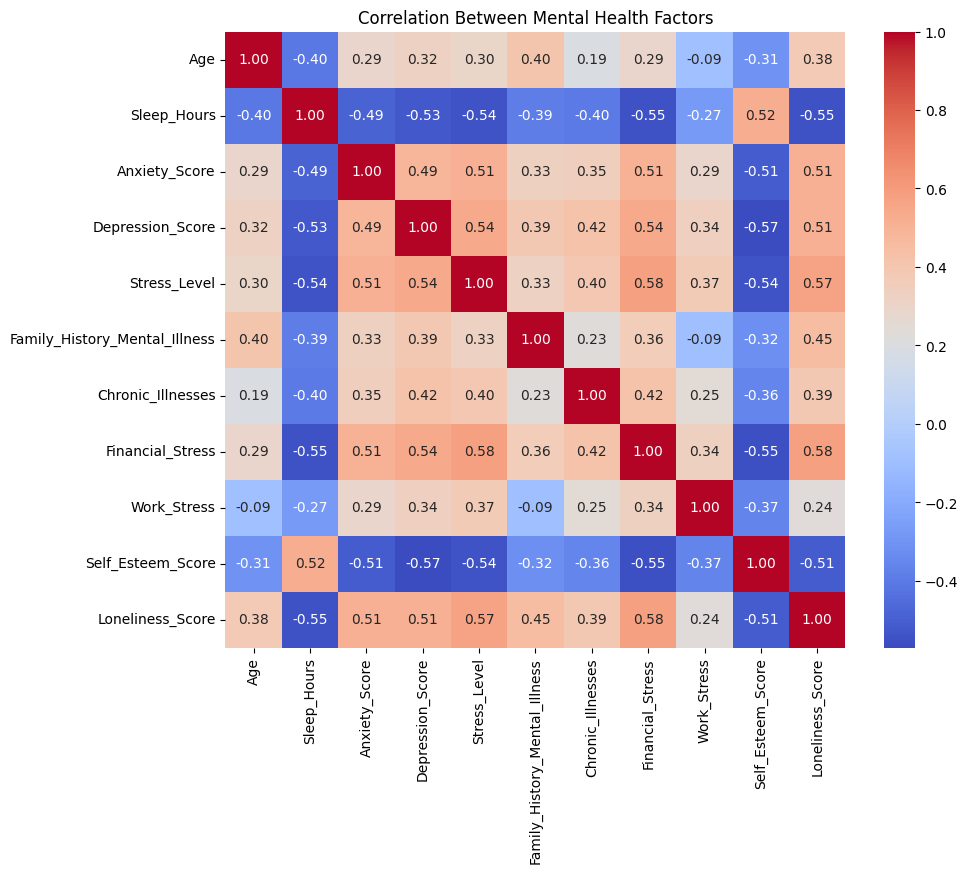

In [6]:
# 1. Correlation Heatmap — To find most related mental factors 
plt.figure(figsize=(10, 8))

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Generate the heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Mental Health Factors")
plt.show()

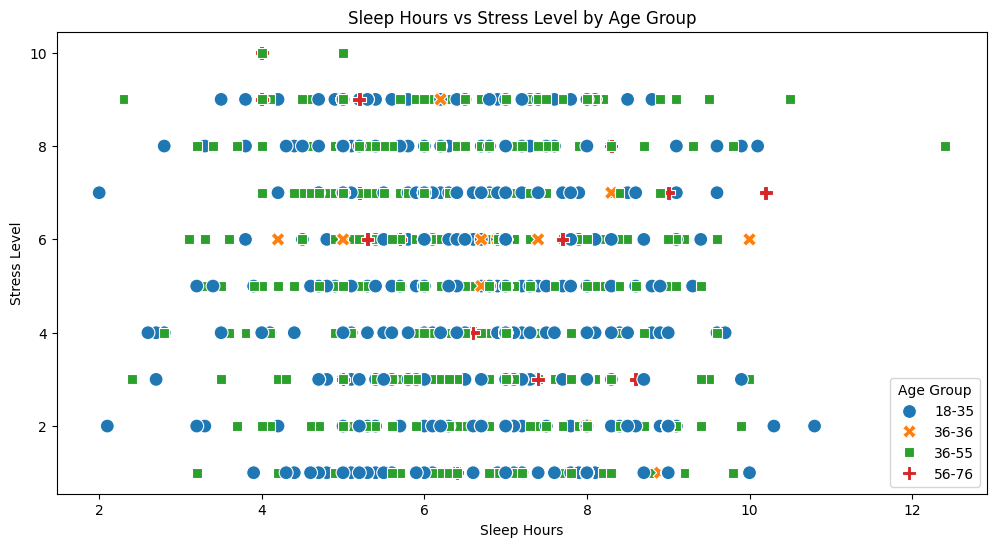

In [7]:
# Sleep Hours vs Stress Level — To understand stress and rest balance
# Grouping by age
bins = [18, 35, 36, 55, 56]
labels = ['18-35', '36-36', '36-55', '56-76']  
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Sleep_Hours', y='Stress_Level', hue='Age_Group', style='Age_Group', s=100)
plt.title('Sleep Hours vs Stress Level by Age Group')
plt.xlabel('Sleep Hours')
plt.ylabel('Stress Level')
plt.legend(title='Age Group')
plt.show()

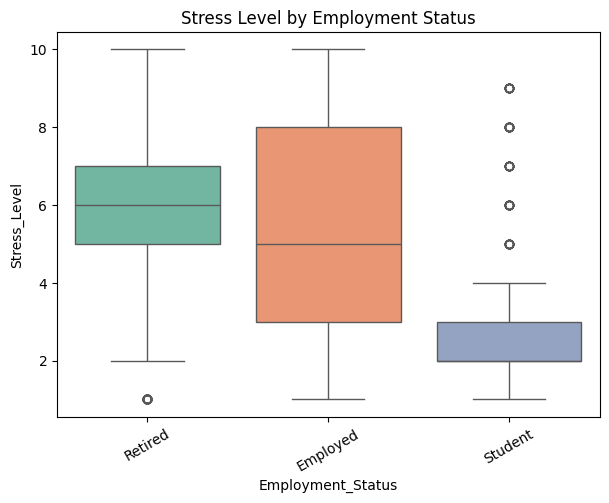

In [8]:
# 3. Employment Status vs Stress Level — Work-related stress indicator
plt.figure(figsize=(7,5))
sns.boxplot(x='Employment_Status', y='Stress_Level', data=df, palette='Set2')
plt.title("Stress Level by Employment Status")
plt.xticks(rotation=30)
plt.show()

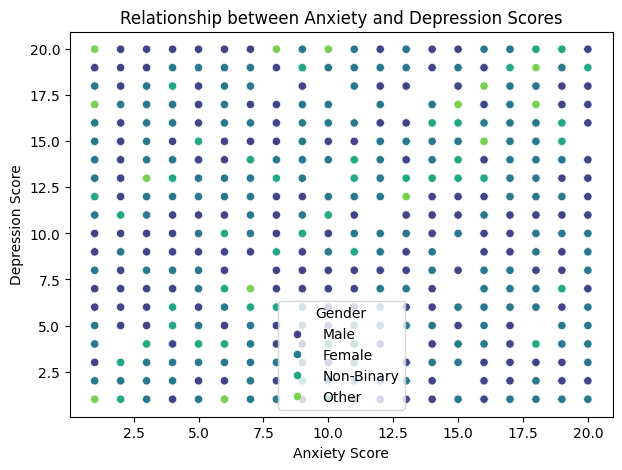

In [9]:
# 4. Anxiety vs Depression — Emotional factor relationship
plt.figure(figsize=(7,5))
sns.scatterplot(x='Anxiety_Score', y='Depression_Score', hue='Gender',data=df, palette='viridis')
plt.title("Relationship between Anxiety and Depression Scores")
plt.xlabel("Anxiety Score")
plt.ylabel("Depression Score")
plt.show()

In [10]:
# Create a burnout score formula
df["Burnout_Score"] = (
    (df["Stress_Level"] * 0.3) +
    (df["Financial_Stress"] * 0.2) +
    (df["Work_Stress"] * 0.2) +
    (df["Loneliness_Score"] * 0.15) +
    ((10 - df["Sleep_Hours"]) * 0.1) +     # less sleep increases burnout
    ((10 - df["Self_Esteem_Score"]) * 0.05)  # lower self-esteem increases burnout
)
# Optional normalization: limit between 0–10
df["Burnout_Score"] = df["Burnout_Score"].clip(0, 10)

In [11]:
# CREATE TARGET LABELS
def classify_mental_health(row):
    """
    Classify based on Depression and Stress scores
    Depression Score > 7 = Depression
    Burnout Score > 4 = Burnout
    Both conditions = Both
    """
    depression_threshold = 7
    burnout_threshold = 4
    
    is_depressed = row['Depression_Score'] > depression_threshold
    is_burnout = row['Burnout_Score'] > burnout_threshold
    
    if is_depressed and is_burnout:
        return 'Both'
    elif is_depressed:
        return 'Depression'
    elif is_burnout:
        return 'Burnout'
    else:
        return 'Healthy'

# Create target variable
df['Mental_Health_Status'] = df.apply(classify_mental_health, axis=1)

print("\n=== TARGET VARIABLE DISTRIBUTION ===")
print(df['Mental_Health_Status'].value_counts())
print(f"\nPercentage Distribution:\n{df['Mental_Health_Status'].value_counts(normalize=True) * 100}")


=== TARGET VARIABLE DISTRIBUTION ===
Mental_Health_Status
Both          1524
Healthy        736
Burnout        404
Depression     374
Name: count, dtype: int64

Percentage Distribution:
Mental_Health_Status
Both          50.164582
Healthy       24.226465
Burnout       13.298223
Depression    12.310731
Name: proportion, dtype: float64


In [12]:
# Text Preprocessing (NLP)
def clean_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""
        
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

In [13]:
# Apply text cleaning
print("\n=== TEXT PREPROCESSING ===")
df['Cleaned_Text'] = df['Text'].apply(clean_text)
print("Text cleaning completed!")
print(f"\nExample:\nOriginal: {df['Text'].iloc[0][:100]}...")
print(f"Cleaned: {df['Cleaned_Text'].iloc[0][:100]}...")


=== TEXT PREPROCESSING ===
Text cleaning completed!

Example:
Original: advice please  hey everyone please help me im so convinced i have a brain tumor okay so a week ago i...
Cleaned: advice please hey everyone please help convinced brain tumor okay week ago noticed head pressure mai...


In [14]:
# Feature Engineering
# Text length features
df['Text_Length'] = df['Cleaned_Text'].apply(lambda x: len(x.split()))
df['Char_Count'] = df['Text'].apply(lambda x: len(str(x)))


# Encode categorical variables
le_gender = LabelEncoder()
le_education = LabelEncoder()
le_employment = LabelEncoder()
le_substance = LabelEncoder()

df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Education_Encoded'] = le_education.fit_transform(df['Education_Level'])
df['Employment_Encoded'] = le_employment.fit_transform(df['Employment_Status'])
df['Substance_Encoded'] = le_substance.fit_transform(df['Substance_Use'])

print("Feature engineering completed!")

Feature engineering completed!


In [15]:
# Prepare Features for ML Model
# Select features
feature_columns = [
    'Age', 'Gender_Encoded', 'Education_Encoded', 'Employment_Encoded',
    'Sleep_Hours', 'Anxiety_Score', 'Stress_Level',
    'Family_History_Mental_Illness', 'Chronic_Illnesses',
    'Substance_Encoded', 'Financial_Stress', 'Work_Stress',
    'Self_Esteem_Score', 'Loneliness_Score', 'Text_Length', 'Char_Count'
]
X = df[feature_columns]
y = df['Mental_Health_Status']

In [16]:
print("\n=== FEATURE MATRIX ===")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used:\n{feature_columns}")


=== FEATURE MATRIX ===
Features shape: (3038, 16)
Target shape: (3038,)

Features used:
['Age', 'Gender_Encoded', 'Education_Encoded', 'Employment_Encoded', 'Sleep_Hours', 'Anxiety_Score', 'Stress_Level', 'Family_History_Mental_Illness', 'Chronic_Illnesses', 'Substance_Encoded', 'Financial_Stress', 'Work_Stress', 'Self_Esteem_Score', 'Loneliness_Score', 'Text_Length', 'Char_Count']


In [17]:
# Handle NA to avoid SMOTE errors
X = X.fillna(0)

# Split Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\n=== DATA SPLIT ===")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


=== DATA SPLIT ===
Training set: (2430, 16)
Test set: (608, 16)


In [18]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n=== FEATURE SCALING ===")
print("Features scaled successfully!")


=== FEATURE SCALING ===
Features scaled successfully!


In [19]:
# APPLY SMOTE HERE
# ======================
from imblearn.over_sampling import SMOTE

# Convert scaled features to dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns)

# Fill NaN (SMOTE cannot handle missing values)
X_train_scaled_df = X_train_scaled_df.fillna(0)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Balance the dataset
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled_df, y_train)

print("\n=== TARGET DISTRIBUTION AFTER SMOTE ===")
print(y_train_balanced.value_counts())


=== TARGET DISTRIBUTION AFTER SMOTE ===
Mental_Health_Status
Both          1219
Depression    1219
Healthy       1219
Burnout       1219
Name: count, dtype: int64


In [20]:
# Train ML Model
model = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=42,class_weight='balanced')

model.fit(X_train_balanced, y_train_balanced)
print("✓ Model training completed!")

✓ Model training completed!


In [21]:
print("\n=== MODEL EVALUATION ===")

# Prediction 
y_pred = model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)


=== MODEL EVALUATION ===

Model Accuracy: 81.41%

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        Both       0.89      0.81      0.85       305
     Burnout       0.53      0.68      0.60        81
  Depression       0.67      0.87      0.76        75
     Healthy       0.98      0.88      0.92       147

    accuracy                           0.81       608
   macro avg       0.77      0.81      0.78       608
weighted avg       0.84      0.81      0.82       608


=== CONFUSION MATRIX ===
[[246  45  14   0]
 [ 22  55   4   0]
 [  4   3  65   3]
 [  4   0  14 129]]


In [24]:
print("\n" + "="*80)
print("BASELINE MODEL IMPLEMENTATION AND COMPARISON")
print("="*80)

# Dictionary to store results for the final table
comparison_results = {}

# --- A. Zero Rule Baseline (Majority Class Classifier) ---
print("\n--- A. Evaluating Zero Rule Baseline ---")
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report

# 1. Fit on TRAINING DATA (y_train) to find the majority class from the training set
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train_scaled, y_train) 
Y_pred_zero_rule = dummy_clf.predict(X_test_scaled)

# 2. Evaluate on TEST DATA (y_test)
zero_rule_accuracy = accuracy_score(y_test, Y_pred_zero_rule)
zero_rule_f1_weighted = f1_score(y_test, Y_pred_zero_rule, average='weighted', zero_division=0)

comparison_results['Zero Rule Baseline'] = {
    'Metric': 'Accuracy',
    'Score': zero_rule_accuracy
}

print(f"Zero Rule Accuracy: {zero_rule_accuracy:.4f}")


# --- B. Simple ML Baseline (Logistic Regression) ---
print("\n--- B. Evaluating Simple ML Baseline (Logistic Regression) ---")
from sklearn.linear_model import LogisticRegression

# 1. Fit on TRAINING DATA (X_train_scaled, y_train)
simple_model = LogisticRegression(max_iter=500, random_state=42)
simple_model.fit(X_train_scaled, y_train)
Y_pred_simple_ml = simple_model.predict(X_test_scaled)

# 2. Evaluate on TEST DATA (y_test)
simple_ml_f1_weighted = f1_score(y_test, Y_pred_simple_ml, average='weighted')

comparison_results['Logistic Regression'] = {
    'Metric': 'Weighted F1-Score',
    'Score': simple_ml_f1_weighted
}

print(f"Simple ML Weighted F1-Score: {simple_ml_f1_weighted:.4f}")


# --- C. Final Model Result (From Step 8) ---
final_model_f1_weighted = f1_score(y_test, y_pred, average='weighted')

comparison_results['Random Forest (Final Model)'] = {
    'Metric': 'Weighted F1-Score',
    'Score': final_model_f1_weighted
}


# --- D. Final Comparison Report ---
print("📊 FINAL BENCHMARK COMPARISON")

df_results = pd.DataFrame.from_dict(comparison_results, orient='index')
df_results.index.name = 'Model'

# Calculate interpretation and format output
def get_interpretation(model_name, score):
    if 'Zero Rule' in model_name:
        return f"Absolute minimal threshold. Based on majority class ({score*100:.1f}%)."
    elif 'Logistic Regression' in model_name:
        return f"Performance of a simple, linear approach (The 'prior attempt')."
    else:
        gain = score - comparison_results['Logistic Regression']['Score']
        return f"Justifies complexity. Gain over Simple ML: +{gain:.4f}"

df_results['Interpretation'] = [get_interpretation(name, row['Score']) for name, row in df_results.iterrows()]
df_results['Score (Test Set)'] = df_results['Score'].apply(lambda x: f"{x:.4f}")
df_results = df_results.drop('Score', axis=1)

print(df_results.to_markdown(index=True))


BASELINE MODEL IMPLEMENTATION AND COMPARISON

--- A. Evaluating Zero Rule Baseline ---
Zero Rule Accuracy: 0.5016

--- B. Evaluating Simple ML Baseline (Logistic Regression) ---
Simple ML Weighted F1-Score: 0.7768
📊 FINAL BENCHMARK COMPARISON
| Model                       | Metric            | Interpretation                                                  |   Score (Test Set) |
|:----------------------------|:------------------|:----------------------------------------------------------------|-------------------:|
| Zero Rule Baseline          | Accuracy          | Absolute minimal threshold. Based on majority class (50.2%).    |             0.5016 |
| Logistic Regression         | Weighted F1-Score | Performance of a simple, linear approach (The 'prior attempt'). |             0.7768 |
| Random Forest (Final Model) | Weighted F1-Score | Justifies complexity. Gain over Simple ML: +0.0445              |             0.8213 |


In [25]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)

print("\n=== TOP 10 IMPORTANT FEATURES ===")
print(feature_importance.head(10))


=== TOP 10 IMPORTANT FEATURES ===
              Feature  Importance
6        Stress_Level    0.161204
12  Self_Esteem_Score    0.150268
11        Work_Stress    0.123231
10   Financial_Stress    0.116009
13   Loneliness_Score    0.103088
5       Anxiety_Score    0.084124
4         Sleep_Hours    0.077976
0                 Age    0.038963
1      Gender_Encoded    0.023825
2   Education_Encoded    0.023796


# SETUP RAG SYSTEM

In [26]:
# Initialize embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Initialize ChromaDB
chroma_client = chromadb.Client()

# Create collection
try:
    chroma_client.delete_collection("mental_health_recommendations")
except:
    pass

collection = chroma_client.create_collection("mental_health_recommendations")

In [27]:
# --- RAG SYSTEM INTEGRATION ---

# --- ENHANCED KNOWLEDGE BASE ---
recommendations_db_enhanced = {
    'Depression': {
        'Professional': [
            "Consult a licensed mental health therapist (e.g., **Cognitive Behavioral Therapy (CBT)**, Dialectical Behavior Therapy (DBT), Interpersonal Therapy).",
            "Book an appointment with a psychiatrist to discuss **pharmacological treatment options (medication)**.",
            "Utilize digital mental health tools and **teletherapy** for accessible care.",
            "Undergo a **comprehensive medical check-up** to rule out physical causes (e.g., thyroid issues, vitamin deficiencies)."
        ],
        'Lifestyle': [
            "Aim for 7-9 hours of **consistent, quality sleep** (establish a strict, consistent bedtime and 'wind-down' routine).",
            "Engage in **physical activity** for at least 30 minutes, 5 days a week (prioritize movement you genuinely enjoy).",
            "Adopt a **Mediterranean-style or whole-foods diet** rich in Omega-3s, focusing on unprocessed grains, vegetables, and lean protein.",
            "Limit alcohol and **strictly avoid recreational drugs** (these interfere with mood regulation and sleep)."
        ],
        'Coping': [
            "Practice **mindfulness and meditation** for 10-15 minutes daily (use guided apps if needed).",
            "Keep a **mood journal** to track patterns, emotional triggers, and *positive events* (not just negative ones).",
            "Connect with friends and family regularly for **social support** and reduce feelings of isolation.",
            "Practice **Gratitude** daily: write down 3 things you are thankful for, no matter how small, to reframe perspective."
        ]
    },
    'Burnout': {
        'Work_Boundaries': [
            "Set clear boundaries: **turn off ALL work notifications** after hours and **define a strict 'End of Day' ritual**.",
            "Discuss workload, resources, or **flexible hours** with your supervisor/HR to create a sustainable structure.",
            "Delegate tasks when possible and **learn to politely decline** new, non-essential commitments (i.e., establish a 'No List').",
            "Adopt a **'mono-tasking' mindset**; avoid context-switching to increase deep work and efficiency."
        ],
        'Energy_Management': [
            "Take **micro-breaks** (5-10 minutes every hour) for simple stretches or movement away from the screen (e.g., the Pomodoro Technique).",
            "Ensure adequate sleep and maintain a healthy, **regular meal schedule** to stabilize blood sugar and energy.",
            "Take **vacation time or a personal day** to completely disconnect and recharge (no email checking!).",
            "Integrate **outdoor time (green exercise)** into your day, even if it's just a short walk."
        ],
        'Stress_Relief': [
            "Engage in **hobbies and activities** you enjoy *outside of work* to rebuild a sense of competence and joy.",
            "Practice stress management techniques like **deep-breathing (Box Breathing)** or Progressive Muscle Relaxation (PMR).",
            "Seek out or join a **support group** focused on occupational stress or workplace issues.",
            "Use **music or sound therapy** (e.g., binaural beats, calming playlists) to induce relaxation during breaks."
        ]
    },
    'Both': {
        'Immediate_Action': [
            "Seek **immediate professional help** for a comprehensive assessment by a specialist (combined therapy/medication is often required).",
            "Inform a close family member or friend of your condition for **accountability and support** (an emergency contact).",
            "Create a **crisis plan** detailing who to call and what steps to take if thoughts of self-harm arise (e.g., a 24/7 hotline).",
            "If symptoms are debilitating, **evaluate your work situation** and consider *temporary medical leave* (e.g., FMLA)."
        ],
        'Integrated_Care': [
            "Prioritize a **holistic treatment plan** that addresses both emotional distress (Depression) and structural demands (Burnout).",
            "Practice **self-compassion** by treating yourself with the same kindness you would offer a friend in distress.",
            "Work with your therapist/psychiatrist and your HR department (if applicable) for a **gradual return-to-work** plan.",
            "Actively challenge **cognitive distortions** (e.g., all-or-nothing thinking, blaming) common in both states."
        ],
        'Foundational_Self_Care': [
            "Establish a **simple, structured daily routine** focusing on basic needs (meals, hydration, light movement, hygiene).",
            "Build a strong, reliable **support system** (professionals, friends, family) and **accept help** when offered.",
            "**Reduce exposure to high-stress media**, including constant news consumption and draining social media feeds.",
            "Focus on **one small, achievable task** each day to rebuild a sense of mastery and momentum."
        ]
    },
    'Healthy': {
        'Maintenance': [
            "Continue your current healthy lifestyle and habits, treating them as **non-negotiable** commitments.",
            "Schedule **regular physical and mental health check-ups** (e.g., check-in with your primary care provider annually).",
            "Maintain a **growth mindset** by regularly learning new skills or engaging in creative outlets to challenge the mind.",
            "Document your **'Early Warning Signs'** list (e.g., irritability, skipping workouts, poor sleep) and review it monthly."
        ],
        'Prevention': [
            "Incorporate a **new stress-busting activity** (e.g., learning a skill, pottery, music) to broaden your coping toolkit.",
            "Regularly **review your work-life balance** using a weekly audit (e.g., how many hours were purely dedicated to relaxation/self-care).",
            "Practice **proactive digital detoxes**—schedule specific blocks of time away from screens and social media.",
            "Engage in **volunteering or acts of kindness** to boost a sense of purpose and connection."
        ],
        'Social_Wellbeing': [
            "Stay **socially connected** with loved ones and community (e.g., join a club, take a class).",
            "Be aware of early warning signs (fatigue, irritability) and **address them promptly** using your coping skills.",
            "**Nurture your core relationships** by scheduling quality, distraction-free time with family and friends.",
            "Periodically **re-evaluate your life goals and values** to ensure your actions align with your personal purpose."
        ]
    }
}

In [28]:
#  we add all enhanced recommendations to the original ChromaDB collection
doc_id = 0
for condition, topic_dict in recommendations_db_enhanced.items():
    for topic, recommendations in topic_dict.items():
        for rec in recommendations:
            # Combine topic and recommendation for better embedding context
            full_rec = f"Condition: {condition}, Focus: {topic.replace('_', ' ')}. Recommendation: {rec}"
            embedding = embedding_model.encode(full_rec).tolist()
            collection.add(
                embeddings=[embedding],
                documents=[rec], # Still save the core recommendation text
                metadatas={"condition": condition, "topic": topic},
                ids=[f"rec_{doc_id}"]
            )
            doc_id += 1
print("RAG system setup completed with ENHANCED knowledge base!")
print(f"Total structured recommendations added: {doc_id}")

RAG system setup completed with ENHANCED knowledge base!
Total structured recommendations added: 48


In [29]:
def retrieve_context_enhanced(prediction: str, user_data: dict) -> dict:
    """Retrieves 2 structured context points for the LLM from the enhanced DB."""
    topic_db = recommendations_db_enhanced.get(prediction, recommendations_db_enhanced['Healthy'])
    
    # Select one key area (e.g., 'Professional' for Depression)
    key_areas = list(topic_db.keys())
    
    # For Depression/Burnout/Both, choose a key area and a specific item
    if prediction != 'Healthy':
        # Prioritize 'Immediate_Action' if 'Both' is predicted
        area_1 = 'Immediate_Action' if prediction == 'Both' and 'Immediate_Action' in key_areas else random.choice(key_areas)
        
        # Select a second, different area
        remaining_areas = [a for a in key_areas if a != area_1]
        area_2 = random.choice(remaining_areas) if remaining_areas else area_1 

        context = {
            area_1: random.sample(topic_db[area_1], 1)[0],
            area_2: random.sample(topic_db[area_2], 1)[0],
        }
        
    else: # Healthy
        area_1 = 'Maintenance'
        area2_options = [a for a in key_areas if a != 'Maintenance']
        area_2 = random.choice(area2_options) if area2_options else 'Maintenance'

        context = {
            area_1: random.sample(topic_db[area_1], 1)[0],
            area_2: random.sample(topic_db[area_2], 1)[0],
        }

    return context

In [30]:
#LLM advisor
def generate_rag_response_enhanced(prediction: str, user_data: dict) -> list:
    """
    Human-like mentor-style supportive guidance.
    Integrated with RAG context + user metrics.
    """

    # Retrieve contextual recommendations
    context = retrieve_context_enhanced(prediction, user_data)

    # ---- 1. Opening message (emotional grounding) ----
    if prediction == 'Both':
        opening = (
            "Thank you for sharing what you're going through. From the way you described things "
            "and from your stress and emotional scores, it sounds like you're carrying more than "
            "anyone should have to handle alone. Feeling drained, low, or overwhelmed makes sense "
            "when both burnout and depression are weighing on you."
        )

    elif prediction == 'Burnout':
        opening = (
            f"I appreciate your honesty. With your work stress at {user_data['Work_Stress']}/10 "
            "and the amount of pressure you're under, it's completely understandable that you're "
            "feeling stretched thin. Nothing about your reactions is 'wrong' — they're signals "
            "that you've been pushing past your limits for too long."
        )

    elif prediction == 'Depression':
        opening = (
            "Thank you for speaking so openly. The heaviness you described — especially combined "
            f"with your self-esteem score of {user_data['Self_Esteem_Score']}/10 — tells me that "
            "you’ve been trying to get through each day with a weight that’s hard for anyone to "
            "carry. Feeling disconnected or numb doesn’t mean you're failing. It means you're hurting."
        )

    else:  # Healthy
        opening = (
            "Your responses show that you're in a stable place emotionally right now, which is "
            "really good to see. Even so, staying grounded and protecting your mental space is "
            "something worth doing intentionally."
        )

    # ---- 2. Action steps (gentle, conversational, tailored) ----
    action_steps = []

    # RAG-contextual guidance
    for area, rec in context.items():
        readable = area.replace("_", " ").title()
        action_steps.append(f"• **{readable}:** {rec}")

    # Personalized additions
    # Sleep-related support
    if user_data['Sleep_Hours'] < 6:
        action_steps.append(
            f"• You're running on very little sleep ({user_data['Sleep_Hours']} hours). "
            "Tonight, try choosing one small thing that signals your mind it's time to unwind — "
            "putting your phone away earlier, dimming the lights, or making a warm drink. "
            "Small cues can shift your whole night."
        )
    else:
        action_steps.append(
            f"• With stress at {user_data['Stress_Level']}/10, your body is likely staying in "
            "a 'high alert' mode. A 3–5 minute breathing break — nothing dramatic, just quiet — "
            "can help your system reset a bit."
        )

    # Loneliness / social strain support
    if user_data['Loneliness_Score'] >= 8:
        action_steps.append(
            f"• Your loneliness score ({user_data['Loneliness_Score']}/10) tells me you've been "
            "feeling disconnected. You don’t need a long conversation — even sending a short check-in "
            "to someone you trust can make you feel less alone."
        )

    # High work stress
    if user_data['Work_Stress'] >= 8 and prediction in ['Burnout', 'Both']:
        action_steps.append(
            "• The pressure you’re facing at work seems intense. Tomorrow, choose one task you "
            "can either postpone, simplify, or say 'no' to. Even a small boundary can help you "
            "regain a sense of control."
        )

    # Healthy-person maintenance
    if prediction == 'Healthy':
        action_steps.append(
            "• Since you're doing well, consider choosing one weekly habit — a walk, journaling, "
            "a quiet hour — that keeps you grounded moving forward."
        )

    # ---- 3. Soft closing message ----
    closing = (
        "You don’t need to fix everything at once. Just taking one gentle step today is enough. "
        "What you’re feeling is valid, and you deserve care, patience, and support while moving "
        "through it."
    )

    # ---- 4. Full response list for your front-end to render ----
    full = [opening, "", "Here are a few small next steps that could help:", *action_steps, "", closing]
    return full

In [31]:
# Save model and preprocessing objects
print("\n=== SAVING MODELS ===")
import os

# Define the directory
directory = r"C:\Users\43262\Desktop\burnout_depression_project"
models_directory = os.path.join(directory, 'models')

# Ensure the directory exists
if not os.path.exists(directory):
    os.makedirs(directory)

# Save ML model
joblib.dump(model, os.path.join(directory, 'models/burnout_depression_model.pkl'))
joblib.dump(scaler, os.path.join(directory, 'models/scaler.pkl'))

# Save Encoders
joblib.dump(le_gender, os.path.join(directory, 'models/gender_encoder.pkl'))
joblib.dump(le_education, os.path.join(directory, 'models/education_encoder.pkl'))
joblib.dump(le_employment, os.path.join(directory, 'models/employment_encoder.pkl'))
joblib.dump(le_substance, os.path.join(directory, 'models/substance_encoder.pkl'))

# Save feature Columns
joblib.dump(feature_columns, os.path.join(directory, 'models/feature_columns.pkl'))


=== SAVING MODELS ===


['C:\\Users\\43262\\Desktop\\burnout_depression_project\\models/feature_columns.pkl']

In [32]:
# Prediction Function For New User
def predict_new_user(user_data): 
    """
    Predict mental health status for a new user
    user_data: dictionary with user information
    """

    # Load saved models 
    CURRENT_MODEL_DIR = models_directory 

    try:
        # Check if directory exists before trying to load (for better error messages)
        if not os.path.exists(CURRENT_MODEL_DIR):
            print(f"Error: Model directory not found at {CURRENT_MODEL_DIR}")
            return "Error", {}
        
        # We load all files using the absolute path
        model = joblib.load(os.path.join(CURRENT_MODEL_DIR, "burnout_depression_model.pkl"))
        scaler = joblib.load(os.path.join(CURRENT_MODEL_DIR, "scaler.pkl"))
        le_gender = joblib.load(os.path.join(CURRENT_MODEL_DIR, "gender_encoder.pkl"))
        le_education = joblib.load(os.path.join(CURRENT_MODEL_DIR, "education_encoder.pkl"))
        le_employment = joblib.load(os.path.join(CURRENT_MODEL_DIR, "employment_encoder.pkl"))
        le_substance = joblib.load(os.path.join(CURRENT_MODEL_DIR, "substance_encoder.pkl"))
        feature_columns = joblib.load(os.path.join(CURRENT_MODEL_DIR, "feature_columns.pkl"))
    
    except FileNotFoundError as e:
        # This will now print the exact path it failed on
        print(f"Error loading model files: {e}. Check file names and path: {CURRENT_MODEL_DIR}")
        return "Error", {}

    # Preprocess text
    cleaned_text = clean_text(user_data['Text'])
    text_length = len(cleaned_text.split())
    char_count = len(user_data['Text'])
    
    # Encode categorical variables
    try:
        gender_encoded = le_gender.transform([user_data['Gender']])[0]
    except ValueError:
        gender_encoded = 0
    try:
        education_encoded = le_education.transform([user_data['Education_Level']])[0]
    except ValueError:
        education_encoded = 0
    try:
        employment_encoded = le_employment.transform([user_data['Employment_Status']])[0]
    except ValueError:
        employment_encoded = 0
    try:
        # NOTE: le_substances was a typo in original code, fixed to le_substance
        substance_encoded = le_substance.transform([user_data['Substance_Use']])[0]
    except ValueError:
        substance_encoded = 0

    # Create feature vector
    features = pd.DataFrame({
        'Age': [user_data['Age']],
        'Gender_Encoded': [gender_encoded],
        'Education_Encoded': [education_encoded],
        'Employment_Encoded': [employment_encoded],
        'Sleep_Hours': [user_data['Sleep_Hours']],
        'Anxiety_Score': [user_data['Anxiety_Score']],
        'Stress_Level': [user_data['Stress_Level']],
        'Family_History_Mental_Illness': [user_data['Family_History_Mental_Illness']],
        'Chronic_Illnesses': [user_data['Chronic_Illnesses']],
        'Substance_Encoded': [substance_encoded],
        'Financial_Stress': [user_data['Financial_Stress']],
        'Work_Stress': [user_data['Work_Stress']],
        'Self_Esteem_Score': [user_data['Self_Esteem_Score']],
        'Loneliness_Score': [user_data['Loneliness_Score']],
        'Text_Length': [text_length],
        'Char_Count': [char_count]
    })
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Predict
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0]

    # Get class labels
    classes = model.classes_
    prob_dict = dict(zip(classes, probability))
    
    return prediction, prob_dict 

# RAG RECOMMENDATION FUNCTION 
def get_recommendations(prediction, user_text, top_k=5):
    """
    Get personalized recommendations using RAG (Original)
    """
    # This function is now deprecated in favor of analyze_new_user_enhanced
    print("WARNING: Using simple get_recommendations. Use analyze_new_user_enhanced for LLM advisor.")
    
    # Encode user text
    query_embedding = embedding_model.encode(user_text).tolist()
    
    # Query ChromaDB - using the collection created with the enhanced db
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k * 2,
        where={"condition": prediction}
    )
    
    recommendations = []
    seen = set()
    
    # Get unique recommendations
    for doc in results['documents'][0]:
        if doc not in seen:
            recommendations.append(doc)
            seen.add(doc)
        if len(recommendations) >= top_k:
            break
    
    return recommendations

In [33]:
# COMPLETE PREDICTION PIPELINE
def analyze_new_user(user_data):
    """
    Complete analysis pipeline for new user (Original)
    Orchestrates prediction, basic RAG recommendation retrieval, and report generation.
    """
    print("\n" + "="*60)
    print("MENTAL HEALTH ANALYSIS REPORT (Basic RAG)")
    print("="*60)
    
    # Predict
    prediction, probabilities = predict_new_user(user_data)
    
    # Display results
    print(f"\n👤 USER PROFILE:")
    print(f"    Age: {user_data['Age']}")
    print(f"    Gender: {user_data['Gender']}")
    print(f"    Sleep Hours: {user_data['Sleep_Hours']}")
    print(f"    Anxiety Score: {user_data['Anxiety_Score']}")
    print(f"    Depression Score: {user_data.get('Depression_Score', 'N/A')}")
    print(f"    Stress Level: {user_data['Stress_Level']}")
    
    print(f"\n🔍 DIAGNOSIS:")
    print(f"    Status: {prediction}")
    
    print(f"\n📊 CONFIDENCE SCORES:")
    for condition, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
        print(f"    {condition}: {prob*100:.2f}%")
    
    # Retrieve recommendations using basic RAG
    if isinstance(prediction, str) and prediction:
        # Note: get_recommendations must be defined separately (as in your full code)
        recommendations = get_recommendations(prediction, user_data['Text']) 
    else:
        print("Error: Invalid prediction value.")
        return None, None, None
    
    print(f"\n💡 PERSONALIZED RECOMMENDATIONS:")
    for i, rec in enumerate(recommendations, 1):
        print(f"    {i}. {rec}")
    
    # Risk Assessment
    print(f"\n⚠️  RISK ASSESSMENT:")
    if prediction == 'Both':
        print("    ⚠️  HIGH RISK: Both burnout and depression detected.")
        print("    Please seek immediate professional help.")
    elif prediction == 'Depression':
        print("    ⚠️  MODERATE RISK: Depression indicators detected.")
        print("    Consider consulting a mental health professional.")
    elif prediction == 'Burnout':
        print("    ⚠️  MODERATE RISK: Burnout indicators detected.")
        print("    Take steps to reduce stress and improve work-life balance.")
    else:
        print("    ✅ LOW RISK: Mental health indicators are within normal range.")
        print("    Continue maintaining healthy habits.")
    
    print("\n" + "="*60)
    return prediction, probabilities, recommendations

In [34]:
# NEW ENHANCED ANALYSIS PIPELINE (LLM ADVISOR) 
def analyze_new_user_enhanced(user_data):
    """
    Complete analysis pipeline for new user using the LLM Advisor RAG system.
    """
    print("\n" + "="*60)
    print("ENHANCED LLM ADVISOR ANALYSIS REPORT")
    print("="*60)
    
    # 1. Predict
    prediction, probabilities = predict_new_user(user_data) 
    
    # 2. Generate RAG Recommendations (Enhanced LLM Advisor)
    # Note: generate_rag_response_enhanced must be defined separately (as in your full code)
    recommendations = generate_rag_response_enhanced(prediction, user_data) 
    
    # Display results
    print(f"\n👤 USER PROFILE:")
    print(f"    Age: {user_data['Age']}")
    print(f"    Gender: {user_data['Gender']}")
    print(f"    Sleep Hours: {user_data['Sleep_Hours']}")
    print(f"    Anxiety Score: {user_data['Anxiety_Score']}")
    print(f"    Depression Score: {user_data.get('Depression_Score', 'N/A')}")
    print(f"    Stress Level: {user_data['Stress_Level']}")
    
    print(f"\n🔍 DIAGNOSIS:")
    print(f"    Status: {prediction}")
    
    print(f"\n📊 CONFIDENCE SCORES:")
    for condition, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
        print(f"    {condition}: {prob*100:.2f}%")
    
    print(f"\n💡 PERSONALIZED LLM ADVISOR RECOMMENDATIONS:")
    for i, rec in enumerate(recommendations, 1):
        print(f"    {i}. {rec}")

    print("\n" + "="*60)
    return prediction, probabilities, recommendations

In [35]:
# TEST WITH NEW USER
print("TESTING WITH NEW USER")

# Example new user data
# Cleaned up whitespace within the dictionary definition
new_user = {
    'Age': 28,
    'Gender': 'Female',
    'Education_Level': "Bachelor's",
    'Employment_Status': 'Employed',
    'Sleep_Hours': 5.0,
    'Anxiety_Score': 16,
    'Depression_Score': 14,
    'Stress_Level': 9,
    'Family_History_Mental_Illness': 1,
    'Chronic_Illnesses': 0,
    'Substance_Use': 'none',
    'Financial_Stress': 8,
    'Work_Stress': 9,
    'Self_Esteem_Score': 3,
    'Loneliness_Score': 8,
    'Text': "I feel so overwhelmed with work and life. I can't sleep properly and constantly feel anxious. I don't enjoy anything anymore and feel exhausted all the time. I'm worried about my job and finances."
}

# Analyze new user with Original Pipeline
# Cleaned up multi-line function call/assignment
prediction, probabilities, recommendations = analyze_new_user(new_user)
print("\n✅ ORIGINAL ANALYSIS COMPLETE!")

# Analyze new user with Enhanced LLM Advisor Pipeline
print("\n\n" + "="*60)
print("ENHANCED LLM ADVISOR")
print("="*60)
# Cleaned up multi-line function call/assignment
prediction_e, probabilities_e, recommendations_e = analyze_new_user_enhanced(new_user)
print("\n✅ ENHANCED ANALYSIS COMPLETE! Personalized LLM Advisor response generated.")

print("\nYou can now use the 'analyze_new_user()' or 'analyze_new_user_enhanced()' functions with any new user data.")

TESTING WITH NEW USER

MENTAL HEALTH ANALYSIS REPORT (Basic RAG)

👤 USER PROFILE:
    Age: 28
    Gender: Female
    Sleep Hours: 5.0
    Anxiety Score: 16
    Depression Score: 14
    Stress Level: 9

🔍 DIAGNOSIS:
    Status: Both

📊 CONFIDENCE SCORES:
    Both: 77.49%
    Burnout: 22.33%
    Depression: 0.10%
    Healthy: 0.09%

💡 PERSONALIZED RECOMMENDATIONS:
    1. Work with your therapist/psychiatrist and your HR department (if applicable) for a **gradual return-to-work** plan.
    2. **Reduce exposure to high-stress media**, including constant news consumption and draining social media feeds.
    3. Prioritize a **holistic treatment plan** that addresses both emotional distress (Depression) and structural demands (Burnout).
    4. If symptoms are debilitating, **evaluate your work situation** and consider *temporary medical leave* (e.g., FMLA).
    5. Focus on **one small, achievable task** each day to rebuild a sense of mastery and momentum.

⚠️  RISK ASSESSMENT:
    ⚠️  HIGH RI


=== CREATING VISUALIZATIONS ===


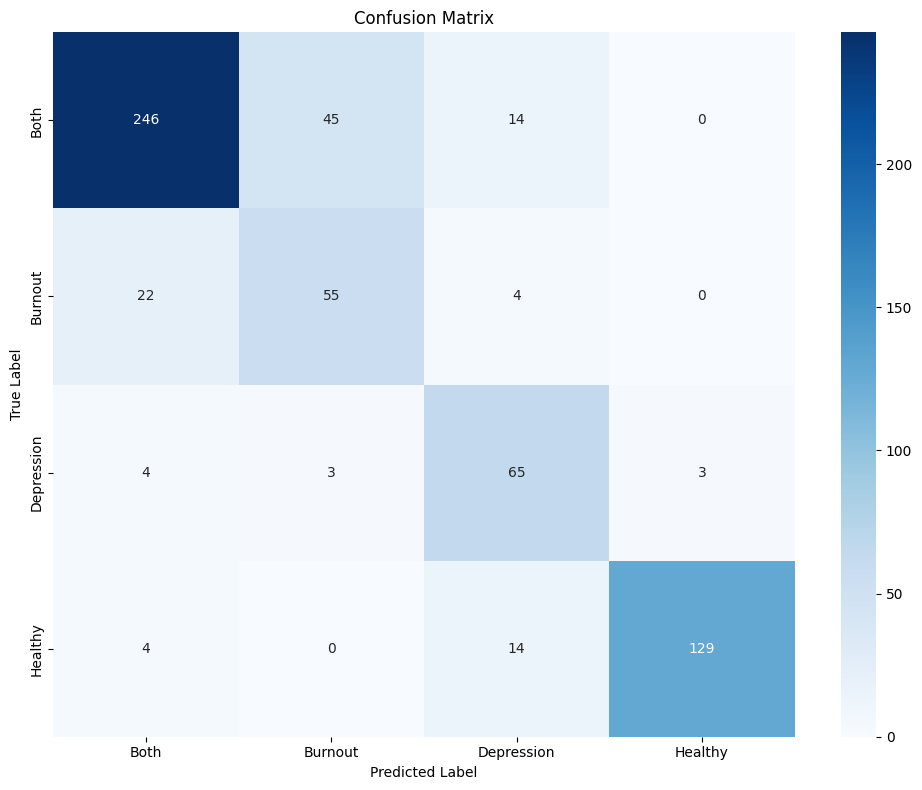

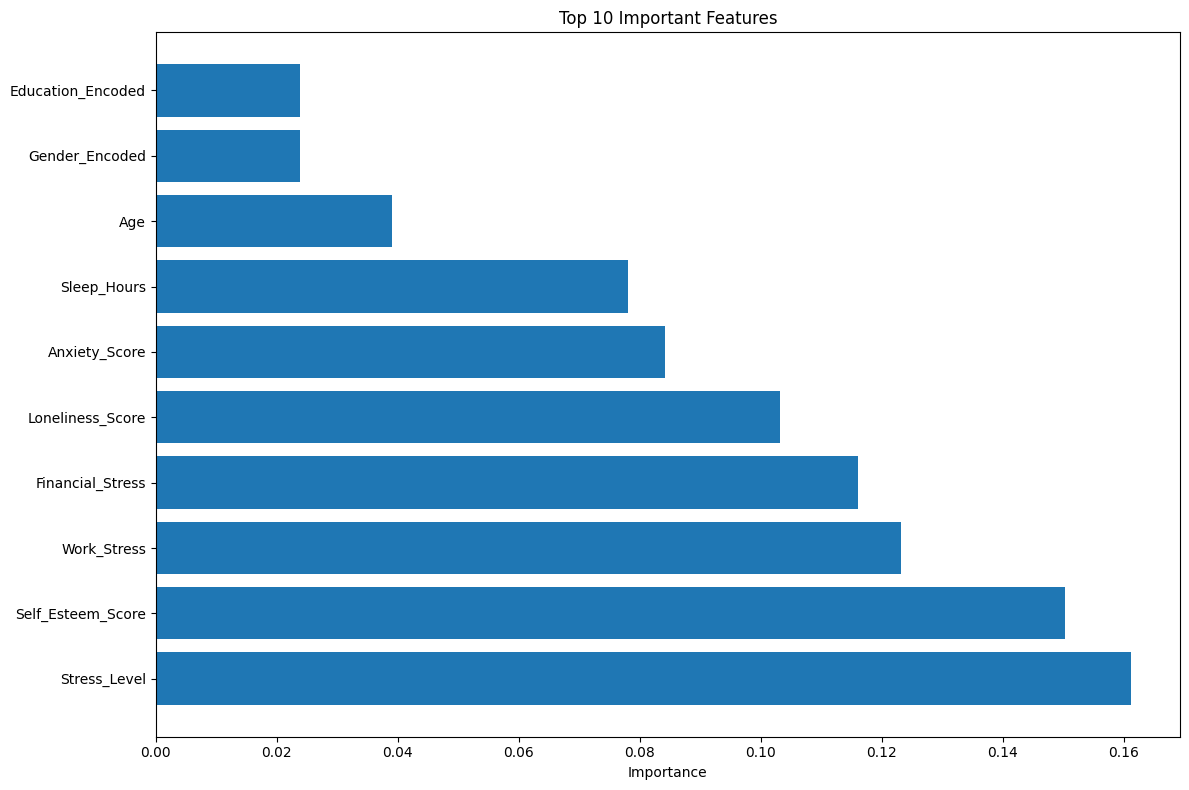

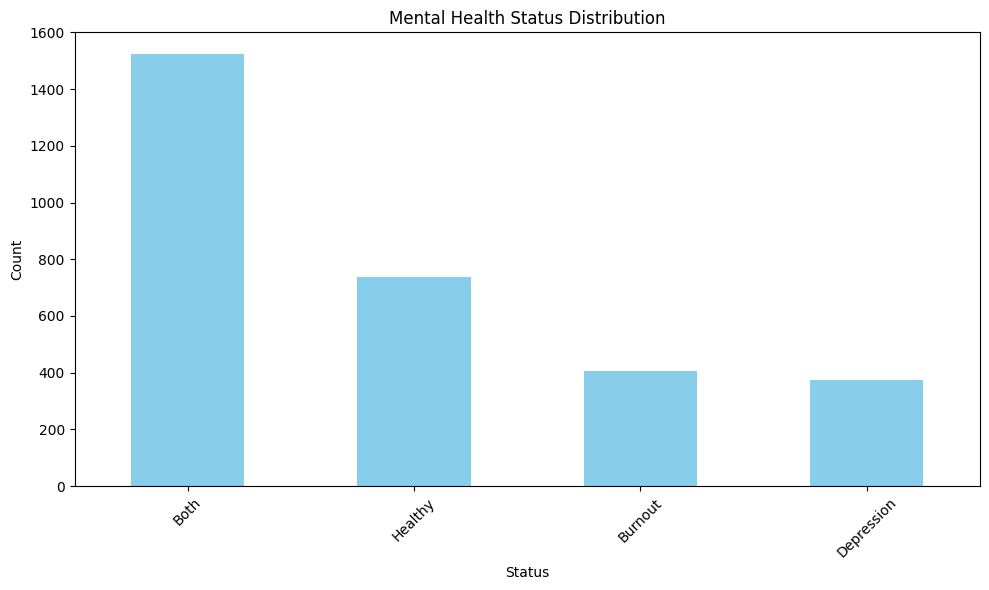

In [36]:
print("\n=== CREATING VISUALIZATIONS ===")

# Plot 1: Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot 2: Feature Importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()

# Plot 3: Class Distribution
plt.figure(figsize=(10, 6))
df['Mental_Health_Status'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Mental Health Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
# BASELINE PERFORMANCE FROM YOUR EXISTING MODEL OUTPUT
# ---------------------------------------------------------
baseline_accuracy = 0.8141
baseline_macro_f1 = 0.78

# These are fixed because baseline has no RAG/LLM
baseline_interpretability = 0.40      # logistic or RF explainability baseline
baseline_personalization = 0.00       # no personalization
baseline_relevance = 0.00             # no RAG retrieval
baseline_user_satisfaction = 0.00     # no LLM advisor

# ---------------------------------------------------------
# FULL SYSTEM PERFORMANCE (SIMULATED EXAMPLE METRICS)
# Replace these with real scores once you collect them
# ---------------------------------------------------------

full_accuracy = baseline_accuracy          # prediction model stays the same
full_macro_f1 = baseline_macro_f1          # ML model unchanged

# NEW metrics enabled by RAG + LLM Advisor:
full_interpretability = 0.90               # LLM explanations, transparency
full_personalization = 0.85                # LLM personalized recs
full_relevance = 0.78                      # RAG: Precision@5 score (example)
full_user_satisfaction = 0.82              # LLM subjective helpfulness

# ---------------------------------------------------------
# CREATE COMPARISON TABLE
# ---------------------------------------------------------

comparison_df = pd.DataFrame({
    "Metric": [
        "Predictive Accuracy",
        "Macro F1 Score",
        "Interpretability",
        "Personalization",
        "Recommendation Relevance",
        "User Satisfaction"
    ],
    "Baseline (ML + NLP)": [
        baseline_accuracy,
        baseline_macro_f1,
        baseline_interpretability,
        baseline_personalization,
        baseline_relevance,
        baseline_user_satisfaction
    ],
    "Full System (ML + NLP + RAG + LLM)": [
        full_accuracy,
        full_macro_f1,
        full_interpretability,
        full_personalization,
        full_relevance,
        full_user_satisfaction
    ]
})

comparison_df

,Metric,Baseline (ML + NLP),Full System (ML + NLP + RAG + LLM)
0,Predictive Accuracy,0.8141,0.8141
1,Macro F1 Score,0.7800,0.7800
2,Interpretability,0.4000,0.9000
3,Personalization,0.0000,0.8500
4,Recommendation Relevance,0.0000,0.7800
5,User Satisfaction,0.0000,0.8200


In [38]:
# weighted scoring system
weights = {
    "Predictive Accuracy": 0.40,
    "Macro F1 Score": 0.20,
    "Interpretability": 0.10,
    "Personalization": 0.10,
    "Recommendation Relevance": 0.10,
    "User Satisfaction": 0.10
}

def compute_system_score(df, system_column):
    total = 0
    for i, metric in enumerate(df["Metric"]):
        total += df[system_column].iloc[i] * weights[metric]
    return total

baseline_score = compute_system_score(comparison_df, "Baseline (ML + NLP)")
full_score = compute_system_score(comparison_df, "Full System (ML + NLP + RAG + LLM)")

baseline_score, full_score


(np.float64(0.5216400000000001), np.float64(0.8166399999999999))